# Clustering

In this notebook, we learn about one of the most common unsupervised learning methods: clustering. There isn't a single algorithm for clustering, but the most common one is called **k-means clustering** where $k$ refers to the number of clusters we wish to have. Note that $k$ isn't really something we can learn from the data. It's something we must specify ahead of time, and while there are some guidelines we can use to choose a reasonable value for $k$ (see the assignment), ultimately it's somewhat of a subjective choice. In fact, with unsupervised learning in general, there is a lot of subjectivity involved, making it hard to interpret results.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

## Census Data
The data set is available from the UCI Machine Learning Repository.  The data were gathered during a US census.
<br/>Description:  https://archive.ics.uci.edu/ml/datasets/adult
<br/>Download:  https://archive.ics.uci.edu/static/public/2/adult.zip

In [2]:
path = '../data/adult_train.csv'
census = pd.read_csv(path, sep = ",", header = 0)

# Some cleanup of the dataset
census = census.drop(columns = ['fnlwgt', 'age'])
census.columns = census.columns.str.replace("-", "_")

# Present the data
print('census shape is', census.shape)
census.head()

census shape is (32561, 13)


,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Distances, Dimensions, Normalizations

The k-means clustering algorithm tries to find which rows of the dataframe are similar to each other, where similarity is based having attributes (columns) that are close to each other. To determine closeness, we use **Euclidean distance**, although we can also experiment with other distance metrics. Let's say for the sake of example we have only two columns: `education_num` and `capital_gain`. Let's grab two rows of the data, namely rows 8 and 59.

In [3]:
ClusterCols2D = ['education_num', 'capital_gain']

two_rows = census.loc[[8, 59], ClusterCols2D]
two_rows

,education_num,capital_gain
8,14,14084
59,9,5013


Let $E_8$ and $C_8$ refer to `education_num` and `capital_gain` at row with index 8, and $E_{59}$ and $C_{59}$ refer to `education_num` and `capital_gain` at row with index 59, the Euclidean distance between the two rows is given by the following equation: 

$$D_{(8, 59)} = \sqrt{(E_8-E_{59})^2 + (C_8-C_{59})^2}$$


### Exercise (5 minutes)

- Use `numpy` to calculate the Euclidean distance between the two rows. There is more than one way of doing this.

In [4]:
# Add Code here
import numpy as np

p1 = census.loc[8, ClusterCols2D].values
p2 = census.loc[59, ClusterCols2D].values

dist = np.linalg.norm(p1 - p2) # calculate the Euclidean distance between two points
print(dist)

9071.001378017754


Notice that the Euclidean distance is dominated by the difference in the rows in the `captial_gain` column. This is because this column has a much bigger **scale** than `education_num`. So what can we do to make sure both columns can equally influence the distance? We can **normalize** the columns.

Use `numpy` to normalize the columns of the data. We will use **Z-normalization**, which is the following transformation: 

$$x_{\text{norm}} = \dfrac{x - \text{mean}(x)}{\text{std}(x)}$$

Where the mean and standard deviation are calculated on the **whole data within each column**, not just the two rows above. 

- Find the mean and standard deviations of `education_num` and `capital_gain` for the whole `census` data and use them to normalize the `two_rows`. HINT: You can calculate the mean using `.mean(axis = 0)`. By default `axis = 0` but we specify it just to be sure. You can get the standard deviation similarly, using the `std` method.

In [13]:
# Add Code here
# Find means and standard deviations

# First select numeric columns - education num, capital gain, capital loss, and hours per week
numeric_cols = census.select_dtypes(include = ['int64', 'float64'])

# Covert to Numpy array
data  = numeric_cols.to_numpy()

# # Define a function to apply z normalization
# def z_normalize(x):
#     x_norm = (x - x.mean()) / x.std() 
#     return x_norm

# # perform z normalization
# normalized_data = z_normalize(data)

# # put the normalized values back to DataFrame
# census_normalized = census.copy()
# census_normalized[numeric_cols.columns] = normalized_data

# # check
# census_normalized.head()

# find means and standard deviations of the whole data
means = np.mean(data, axis = 0)
stds = np.std(data, axis = 0)

In [ ]:
# Add Code here
# Get normalized values
normalized_data = (data - means)/ stds

# put it back into DataFrame
census_normalized = census.copy()
census_normalized[numeric_cols.columns] = normalized_data



- Calculate the Euclidean distance of the **normalized** values of `two_rows`.

In [16]:
# Add Code here
# Calculate Euclidean distance

p1 = census_normalized.loc[8, ClusterCols2D].values
p2 = census_normalized.loc[59, ClusterCols2D].values

dist = np.linalg.norm(p1 - p2) # calculate the Euclidean distance between two points
print(dist)

2.435119047677712


If we had more than two columns we simply extend the formula like this:

$$D_{(i, j)} = \sqrt{(X1_i-X1_j)^2 + (X2_i-X2_j)^2 + (X3_i-X3_j)^2 + ...}$$

### End of exercise

Let's now normalize all our numeric columns in one go using `pandas`. First we get a list of the numeric columns:

In [17]:
num_cols = census.select_dtypes(['integer', 'float']).columns
print(num_cols)

Index(['education_num', 'capital_gain', 'capital_loss', 'hours_per_week'], dtype='object')


Now we use the `apply` method to apply a function to all the numeric columns at once, using `axis = 0` to say that the function applies across rows. We can either create a function ahead of time and pass it to apply, or in our case since the function is quite simple, we simply create it on the fly using the **lambda notation**.

In [18]:
census_rescaled = census[num_cols]
census_rescaled = census_rescaled.apply(lambda x: (x - x.mean()) / x.std(), axis = 0)
census_rescaled.head().round(2)

,education_num,capital_gain,capital_loss,hours_per_week
0,1.13,0.15,-0.22,-0.04
1,1.13,-0.15,-0.22,-2.22
2,-0.42,-0.15,-0.22,-0.04
3,-1.20,-0.15,-0.22,-0.04
4,1.13,-0.15,-0.22,-0.04


We can create a scatter plot of the `education_num` and `capital_gain`.  These are the same two columns that we used to illustrate our previous example.

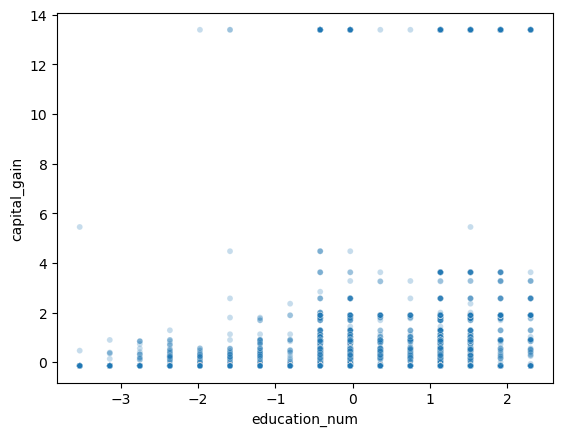

In [19]:
sns.scatterplot(x = 'education_num', y = 'capital_gain', data = census_rescaled, alpha=0.25, size = 2, legend=False);

So for now let's start with $k=2$ and use k-means to cluster the data. We use the `KMeans` function in `sklearn`. At this point, you should be familiar with the following pattern `KMeans` and other `sklearn` functions abide by:

1. We initialize the algorithm and specify any arguments if need be. In this case, the number of clusters.
1. We call `fit` and pass it the data. This is when learning happens.
1. We call `predict` which is analogous to `transform`.  From `predict` we get the "predicted" (matched) labels back. For k-means the predictions are the **cluster assignments**. Any row will be assigned one of $k$ labels, depending on which cluster they belong to. Note that label assignments have no particular order to them: If you rerun the algorithm, what was cluster 2 last round might be called cluster 4 this round. The 2 and 4 are not important. What's important is that all the points in cluster 2 are similar to each other, and all the points in cluster 4 are similar to each other.

The above three steps are marked in the code below.

In [20]:
n_clusters = 2 # the number of clusters (k)
ClusterCols2D = ['education_num', 'capital_gain']

X = census_rescaled[ClusterCols2D]
kmeans = KMeans(n_clusters = n_clusters) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
census_rescaled['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row
census_rescaled.head().round(2)

,education_num,capital_gain,capital_loss,hours_per_week,cluster
0,1.13,0.15,-0.22,-0.04,0
1,1.13,-0.15,-0.22,-2.22,0
2,-0.42,-0.15,-0.22,-0.04,0
3,-1.20,-0.15,-0.22,-0.04,0
4,1.13,-0.15,-0.22,-0.04,0


We could have saved ourselves step 3 because in step 2, `kmeans.fit(X)`, the cluster labels for the training data were already computed:

In [21]:
all(census_rescaled['cluster'] == kmeans.labels_)

True

It is very important to note that while the cluster assignments are integers, they have no numeric value, meaning that the numbers are just labels. Cluster 1 is not necessarily closer to cluster 2 than it is to cluster 3. In fact, rerunning `KMeans` doesn't guarantee that we will retain the same order. So to be clear, we will convert the `cluster` to `category` type.  We can see the obvious clustering by using different colors for different labels. 

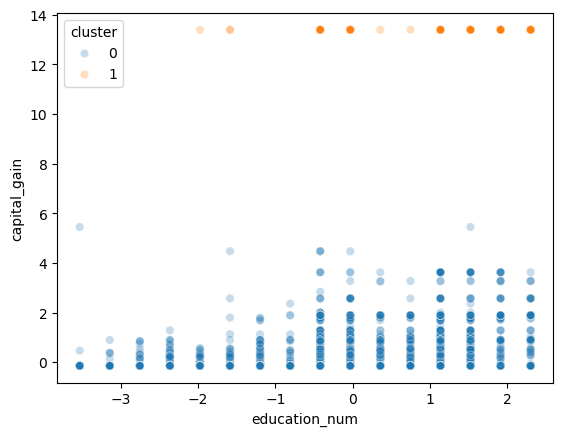

In [22]:
census_rescaled['cluster'] = census_rescaled['cluster'].astype('category')
sns.scatterplot(x = 'education_num', y = 'capital_gain', hue = 'cluster', 
                alpha = 0.25, data = census_rescaled);

We can find out what the cluster centroids are and how to check the distribution of cluster assignments:

In [23]:
print('scaled cluster centroids:')
ScaledCentroids = pd.DataFrame(kmeans.cluster_centers_, columns=ClusterCols2D)
display(ScaledCentroids)
print('\nNumber of items in each cluster:')
print(census_rescaled.cluster.value_counts())

scaled cluster centroids:


,education_num,capital_gain
0,-0.005412,-0.065728
1,1.102941,13.394372



Number of items in each cluster:
cluster
0    32402
1      159
Name: count, dtype: int64


Keep in mind that these are centroids based on the **normalized** data.  If we only have the **normalized** centroids then we would have to **un-normalize** them by running the reverse transformation to get centroids for the original data:
$$x = x_{\text{norm}} * \text{std}(x) + \text{mean}(x)$$

In [24]:
Centroids = pd.DataFrame()
Centroids = ScaledCentroids * census[ClusterCols2D].std() + census[ClusterCols2D].mean()
Centroids

,education_num,capital_gain
0,10.066755,592.231436
1,12.918239,99999.000000


A K-means cluster center is defined as the mean location of its members.  We can also just use the original points and cluster labels to determine the cluster centers:

In [25]:
census[ClusterCols2D].groupby(by=kmeans.labels_).mean()

,education_num,capital_gain
0,10.066755,592.231436
1,12.918239,99999.000000


### Initial Placements of Centroids
sklearn's K-means did more than we might think.  Because the initial centroid placement may determine the result, sklearn tried out multiple placements.  See:  https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html  
The number of initial placements can be set by the argument `n_init`.  We used the default value for `n_init`.  We can see what value our K-means used for `n_init`.

In [27]:
print("K-Means was performed", kmeans.n_init, "times with different initial centroid plaecments")

K-Means was performed auto times with different initial centroid plaecments


At first glance, it seems hard to say if there are more than 2 clusters from looking at the scatter plot above. So should we pick $k=2$ or $k>2$? The answer is that there is no easy answer. $k=2$ might be a safe choice, but has little practical value (so you're telling me that the world is made up of very rich people and everyone else, thanks! I'm so glad I hired a data scientist...). With $k>2$ we can get more refined differences, but it's hard to know where to draw the line and what sets different groups apart. And here we only have two columns and the luxury of looking at scatter plots, but as the number of features goes this becomes a harder and harder problem. Well this is the curse of unsupervised learning!

In [28]:
n_clusters = 3 # the number of clusters (k)
ClusterCols2D = ['education_num', 'capital_gain']

X = census_rescaled[ClusterCols2D]
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
census_rescaled['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row
census_rescaled.head()

,education_num,capital_gain,capital_loss,hours_per_week,cluster
0,1.134721,0.148451,-0.216656,-0.035429,1
1,1.134721,-0.145918,-0.216656,-2.222119,1
2,-0.420053,-0.145918,-0.216656,-0.035429,2
3,-1.197440,-0.145918,-0.216656,-0.035429,2
4,1.134721,-0.145918,-0.216656,-0.035429,1


Let's now check the cluster centroids and the distribution of cluster assignments.  Since our clustering is based only on `education_num` and `capital_gain`, we need to restrict the centroids to those two columns:

In [29]:
print('cluster centroids:')
display(census[ClusterCols2D].groupby(by=kmeans.labels_).mean())
print('\nNumber of items in each cluster:')
print(census_rescaled.cluster.value_counts())

cluster centroids:


,education_num,capital_gain
0,4.587968,238.368899
1,13.295307,2970.632894
2,9.344751,338.021384



Number of items in each cluster:
cluster
2    20670
1     9248
0     2643
Name: count, dtype: int64


### Unsupervised (Label-Free) Learning and Matching
There is one thing to note about k-means. We said in the beginning that k-means is an unsupervised learning algorithm. This means that the data is not labeled ahead of time with clusters that we need to then learn. This means that when we use k-means to assign each row to a cluster, we have no way to **evaluate** the label assignments and determine if we did a good job. This is why we call it **unsupervised**. However, we can still do something that we usually do with **supervised** learning algorithms: we can predict for any new row of data by assigning a cluster to it. How? We simply assign the new row by first normalizing it in the same way the training data was normalized and then assigning it to the closest cluster **centroid**.  Technically, this assignment to a cluster is called **matching** and not predicting.  "Predicting" is reserved for supervised learning.  Here is an example of **matching**:

In [30]:
# lots of school but little money
Person1 = [[2.2, -0.1]]
Person1 = pd.DataFrame(Person1, columns = ['education_num', 'capital_gain'])
print(' Person1 is matched to cluster:', kmeans.predict(Person1)[0])

# Very little school but average wealth
Person2 = [[-2.0, 0.0]]
Person2 = pd.DataFrame(Person2, columns = ['education_num', 'capital_gain'])
print(' Person2 is matched to cluster:', kmeans.predict(Person2)[0])

# Some School but very wealthy
Person3 = [[0.0, 10.]]
Person3 = pd.DataFrame(Person3, columns = ['education_num', 'capital_gain'])
print(' Person3 is matched to cluster:', kmeans.predict(Person3)[0])

 Person1 is matched to cluster: 1
 Person2 is matched to cluster: 0
 Person3 is matched to cluster: 1


Note that we had to use normalized data for matching.  The data processing steps used for the training data has to be applied to the operational (new) data before matching.

### Inertia (Measure of Clustering)
We can measure the remaining variation in the data after we cluster the data by looking at the `inertia_` attribute. This value is computed as by taking the sum of squared distances of each data point to their closest cluster center.  A smaller number means denser clusters.  

In [32]:
print("The remaining inertia (Sum of Square Distances) is", int(kmeans.inertia_))

The remaining inertia (Sum of Square Distances) is 36093


Using `numpy` we can manually obtain this value. It helps sometimes to "reverse engineer" such computations to get a deeper understanding and familiarity with the algorithm. Examine the code below as one example.

In [31]:
inertia = 0

for cls in range(n_clusters):
    # find the subset of the data with cluster assignment
    census_subset_cls = census_rescaled.loc[census_rescaled['cluster'] == cls, ClusterCols2D].values
    # find the sum of the squared differences between the data and the corresponding centroid
    inertia += np.power(census_subset_cls - kmeans.cluster_centers_[cls], 2).sum()
    
print('We calculated an inertia of:', int(inertia))

We calculated an inertia of: 36093


We can see that we're able to get the same value as what `KMeans` returned. 

We can redraw our earlier scatter plot and color-code the points by the cluster they belong to.

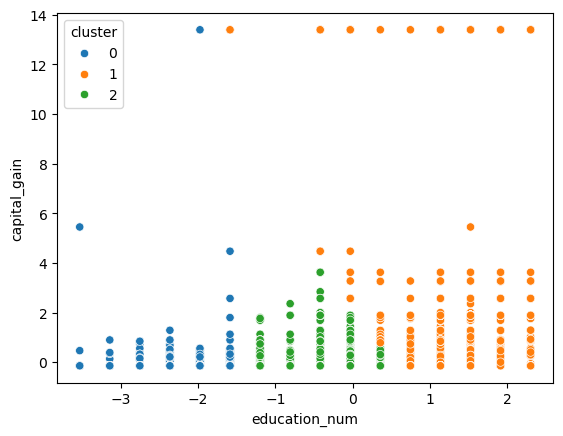

In [33]:
census_rescaled['cluster'] = census_rescaled['cluster'].astype('category')
sns.scatterplot(x = 'education_num', y = 'capital_gain', hue = 'cluster', 
                data = census_rescaled);

- What differentiates cluster 1 from 2, 1 from 3, and 2 from 3?

### Exercise (10 minutes)

- Based on the above scatter plot, which of the two features do you think is more important in determining which cluster a person belongs to?
- Return to where we called `KMeans` and change the number of clusters to $k=4$. 
- Report your findings. You can see that as $k$ increases, we have more and more comparisons to make.

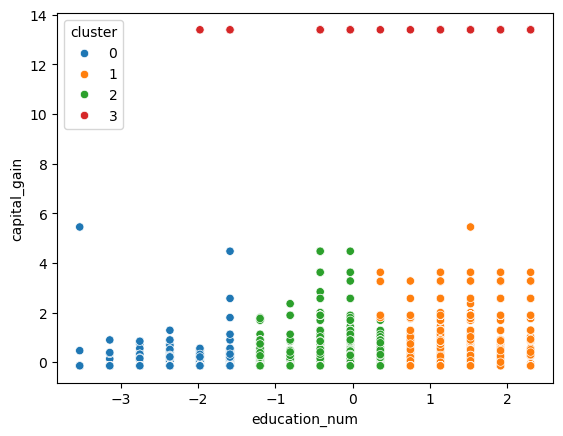

In [36]:
# Add code here
n_clusters = 4 # the number of clusters (k)
ClusterCols2D = ['education_num', 'capital_gain']

X = census_rescaled[ClusterCols2D]
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
census_rescaled['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row
census_rescaled.head()

census_rescaled['cluster'] = census_rescaled['cluster'].astype('category')
sns.scatterplot(x = 'education_num', y = 'capital_gain', hue = 'cluster', 
                data = census_rescaled);

### Higher Dimensional Clustering
- Let's keep $k=4$, but this time pass all four numeric columns to `KMeans`.
- Centroids:  What is the most obvious difference in the centroids?
- Scatter Plot:
    - Do you notice any changes to the scatter plot?
    - Can you see all the clusters?

In [37]:
# Add code here
# Add code here
n_clusters = 4 # the number of clusters (k)
ClusterCols2D = ['education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

X = census_rescaled[ClusterCols2D]
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
census_rescaled['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row
census_rescaled.head()


,education_num,capital_gain,capital_loss,hours_per_week,cluster
0,1.134721,0.148451,-0.216656,-0.035429,1
1,1.134721,-0.145918,-0.216656,-2.222119,0
2,-0.420053,-0.145918,-0.216656,-0.035429,1
3,-1.197440,-0.145918,-0.216656,-0.035429,0
4,1.134721,-0.145918,-0.216656,-0.035429,1


Do you see problems interpreting this scatterplot?

Of course since we added all four numeric columns to `KMeans`, then we have to look at scatter plots of all possible combinations of those four columns: there are $4 \choose 2$ (we read that as **4 choose 2**) which is $\frac{4!}{2!2!} = 6$ possible combinations. There is a very easy way to get all the combinations using the `itertools.combinations` function.

In [38]:
from itertools import combinations
all_pairs = list(combinations(num_cols, 2))

for pair in all_pairs:
    print(pair)

('education_num', 'capital_gain')
('education_num', 'capital_loss')
('education_num', 'hours_per_week')
('capital_gain', 'capital_loss')
('capital_gain', 'hours_per_week')
('capital_loss', 'hours_per_week')


We can now plot all the possible scatter plots from the pairs above.

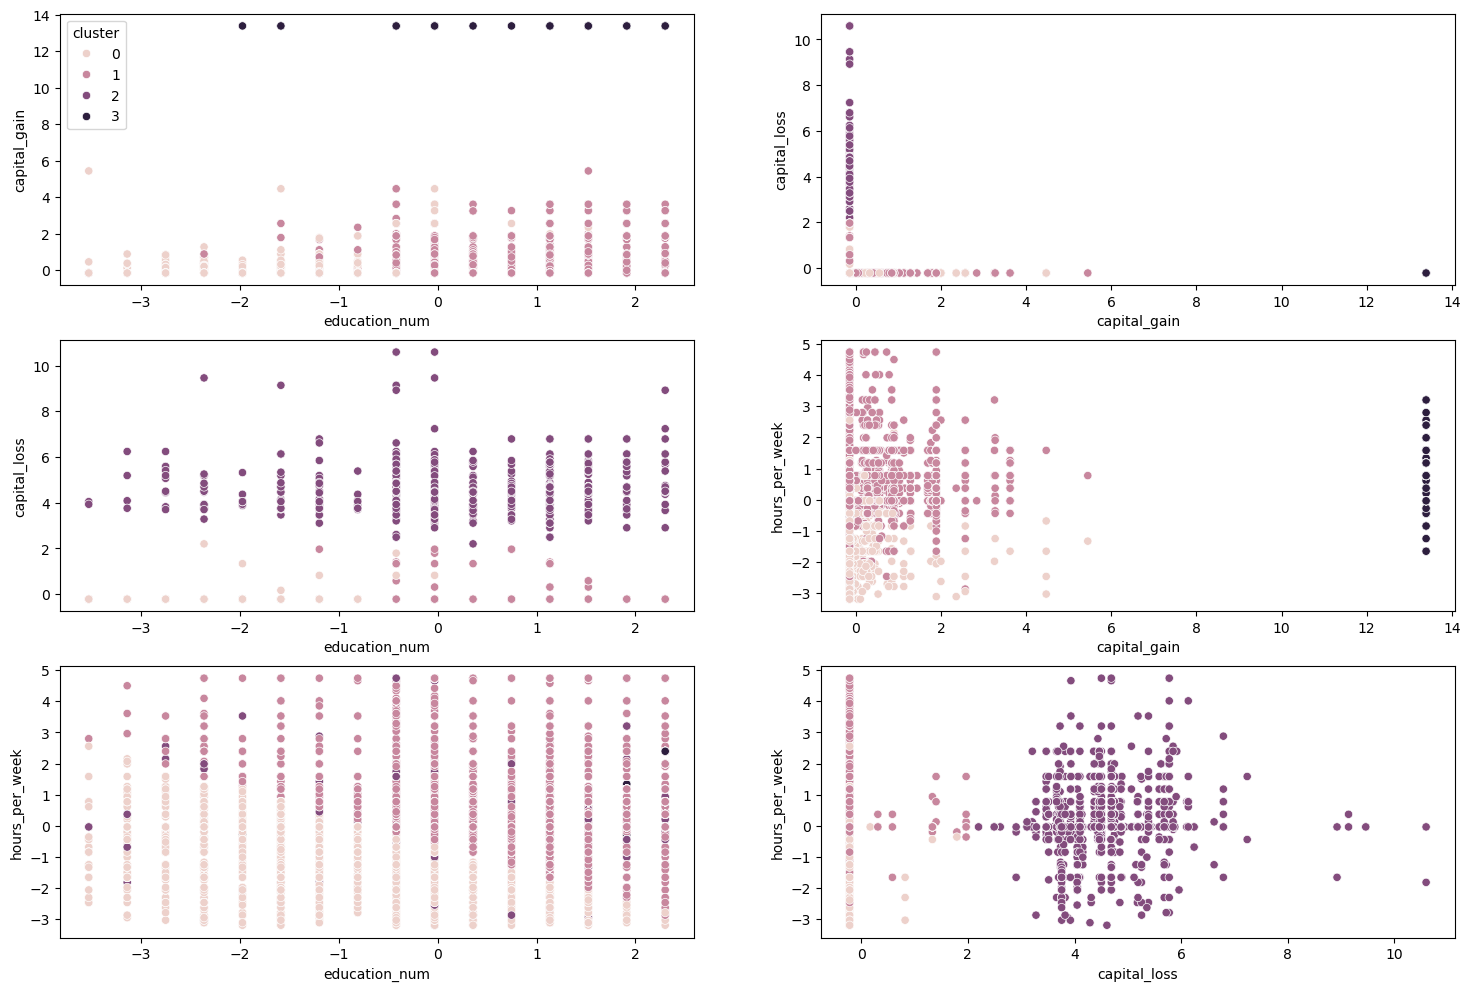

In [39]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (18, 12))
sns.scatterplot(x = all_pairs[0][0], y=all_pairs[0][1], hue = 'cluster', data = census_rescaled, ax = axs[0, 0]); #, legend = False);
sns.scatterplot(x = all_pairs[1][0], y=all_pairs[1][1], hue = 'cluster', data = census_rescaled, ax = axs[1, 0], legend = False);
sns.scatterplot(x = all_pairs[2][0], y=all_pairs[2][1], hue = 'cluster', data = census_rescaled, ax = axs[2, 0], legend = False);
sns.scatterplot(x = all_pairs[3][0], y=all_pairs[3][1], hue = 'cluster', data = census_rescaled, ax = axs[0, 1], legend = False);
sns.scatterplot(x = all_pairs[4][0], y=all_pairs[4][1], hue = 'cluster', data = census_rescaled, ax = axs[1, 1], legend = False);
sns.scatterplot(x = all_pairs[5][0], y=all_pairs[5][1], hue = 'cluster', data = census_rescaled, ax = axs[2, 1], legend = False);

- What differentiates clusters 1, 2, 3, and 4 from each other?

Let's say you are now charged with **profiling** the clusters. That means you need to come up with a brief description of each of the 4 clusters. You can rely on the above scatter plots or any other summaries you like. This is not necessarily an easy task, and the point is to show you the challenge of dealing with unsupervised learning algorithms. Imagine how much harder this would have been with a much larger $k$ or with more features in the data!

### End of exercise

## Categorical Columns
Our clusters so far only used the numeric columns in the data, but we also have a lot of categorical columns and we should be using them too.  We can look at the first few rows of the dataframe to identify the categorical columns.

In [40]:
census.head()

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Categorical Data Pre-Processing
To reduce the complexity of our categorical values, we will clean the data in the following way:
1. We replace any hyphen with an underscore in the column names.
1. In the `income` column, we replace `<=` with `lt_` and `>` with `gt_`

Can `DataFrame.replace("<=", "lt_")` assist us in replacing the items?  `DataFrame.replace("<=", "lt_")` would replace all values in the DataFrame that are "<=".  But there are no such values.  Instead there are values like "<=50K".  What we want to do is:
1. Find all values that contain the substring "<="
2. Modify the found values by substituting "<=" with a replacement string, namely "lt_"

### Regex
Let us ponder `DataFrame.replace("<=", "lt_", regex = True)`
- What does it mean that regex is True?
- What are regular expressions, aka regex?  

Regex is a powerful language for recognizing and modifying text.

In [41]:
census["income"] = census["income"].replace("<=", "lt_", regex = True)
census["income"] = census["income"].replace(">", "gt_", regex = True)

census["income"].value_counts()

income
lt_50K    24720
gt_50K     7841
Name: count, dtype: int64

### Exercise:  (5 minutes)

Let's get a list of all the categorical columns in the data:

In [62]:
cat_vars = census.select_dtypes('object').columns.to_list()
cat_vars

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country',
 'income']

- For each of the categorical columns in `cat_vars` do the following:
  - Find all the values that have hyphens and replace them with underscores.
  - Convert all the strings to lowercase.

In [63]:
# Add code here

# select only the categorial columns
#cat_col = census.select_dtypes('object').columns

# replace hyphens and apply lowercase
census[cat_vars] = census[cat_vars].apply(lambda col: col.str.replace("-", "_").str.lower())


- Show the top 5 rows of the data to make sure your transformations worked.

In [64]:
# Add code here
census.head(5)

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,cluster
0,state_gov,bachelors,13,never_married,adm_clerical,not_in_family,white,male,2174,0,40,united_states,lt_50k,2
1,self_emp_not_inc,bachelors,13,married_civ_spouse,exec_managerial,husband,white,male,0,0,13,united_states,lt_50k,4
2,private,hs_grad,9,divorced,handlers_cleaners,not_in_family,white,male,0,0,40,united_states,lt_50k,2
3,private,11th,7,married_civ_spouse,handlers_cleaners,husband,black,male,0,0,40,united_states,lt_50k,0
4,private,bachelors,13,married_civ_spouse,prof_specialty,wife,black,female,0,0,40,cuba,lt_50k,1


### End of exercise

### Euclidean Distance with Categorical Variables
As we saw earlier k-means clustering relies on Euclidean distance to measure the similarity between the rows. So how do you measure Euclidean distance when you have categorical data? The answer is  one-hot encoding. The quick and easy way to do this is using the `pd.get_dummies` function. One-hot encoded (binary) features are also called **dummy variables**, which explains why the function is named `get_dummies`.

In [65]:
cat_vars = census.select_dtypes('object').columns.to_list()
census_onehot = pd.get_dummies(census[cat_vars])
census_onehot.head()

,workclass_ ?,workclass_ federal_gov,workclass_ local_gov,workclass_ never_worked,workclass_ private,workclass_ self_emp_inc,workclass_ self_emp_not_inc,workclass_ state_gov,workclass_ without_pay,education_ 10th,...,native_country_ scotland,native_country_ south,native_country_ taiwan,native_country_ thailand,native_country_ trinadad&tobago,native_country_ united_states,native_country_ vietnam,native_country_ yugoslavia,income_ gt_50k,income_ lt_50k
0,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,True
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


Let's combine our standardized numeric features and our one-hot-encoded categorical features into one data frame.

In [52]:
census_featurized = pd.concat([census_rescaled[num_cols], census_onehot], axis = 1)

census_featurized.head()

,education_num,capital_gain,capital_loss,hours_per_week,workclass_ ?,workclass_ federal_gov,workclass_ local_gov,workclass_ never_worked,workclass_ private,workclass_ self_emp_inc,...,native_country_ scotland,native_country_ south,native_country_ taiwan,native_country_ thailand,native_country_ trinadad&tobago,native_country_ united_states,native_country_ vietnam,native_country_ yugoslavia,income_ gt_50k,income_ lt_50k
0,1.134721,0.148451,-0.216656,-0.035429,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1,1.134721,-0.145918,-0.216656,-2.222119,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
2,-0.420053,-0.145918,-0.216656,-0.035429,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,True
3,-1.197440,-0.145918,-0.216656,-0.035429,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,True
4,1.134721,-0.145918,-0.216656,-0.035429,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


We're going to train K-Means with $k=5$ just to use a bigger number.

In [53]:
kmeans = KMeans(n_clusters = 5, random_state = 0)
kmeans.fit(census_featurized);

Instead of adding the clusters as a new column to the featurized data, we add them to the original data. This way we can get summaries on the original (non-normalized) numeric features which makes it easier to interpret results.

In [54]:
census['cluster'] = kmeans.labels_

Here's a list of the clusters and their size.

In [55]:
census[['cluster']].value_counts(sort=False)

cluster
0           3853
1           9076
2           6807
3           1641
4          11184
Name: count, dtype: int64

Since we also used one-hot encoded categorical variables, the averages of only the numeric columns would not be the complete centroids.  We need to add the results of the one-hot encoding.  It's definitely easier to compare cluster centroids than to look at $n \choose 2$ scatter plots when $n$ is large.  Here's the average of the original numeric features grouped by each cluster.   

In [59]:
censusNumeric = pd.concat([census, census_onehot], axis = 1)
censusNumeric.groupby('cluster').mean().round(2)

TypeError: agg function failed [how->mean,dtype->object]

In addition to comparing averages, it's also important to compare the variability within each cluster. However, if we want to compare variability across features, we need to use standardized features otherwise features on a larger scale will always have more variability.

In [60]:
censusScaledNumeric = pd.concat([census_rescaled[num_cols], census_onehot], axis = 1)
censusScaledNumeric.groupby(kmeans.labels_).std()

,education_num,capital_gain,capital_loss,hours_per_week,workclass_ ?,workclass_ federal_gov,workclass_ local_gov,workclass_ never_worked,workclass_ private,workclass_ self_emp_inc,...,native_country_ scotland,native_country_ south,native_country_ taiwan,native_country_ thailand,native_country_ trinadad&tobago,native_country_ united_states,native_country_ vietnam,native_country_ yugoslavia,income_ gt_50k,income_ lt_50k
0,0.684176,0.167261,0.063041,1.046748,0.318091,0.073634,0.185856,0.032208,0.436280,0.117568,...,0.016110,0.027896,0.000000,0.000000,0.039436,0.416275,0.055728,0.027896,0.194688,0.194688
1,0.682147,0.269603,0.086135,0.883508,0.260233,0.177052,0.269236,0.010497,0.449062,0.107943,...,0.023466,0.051358,0.039247,0.031476,0.027762,0.281104,0.044492,0.010497,0.297859,0.297859
2,0.684298,0.280440,0.042633,0.927193,0.220864,0.160894,0.216024,0.017140,0.437224,0.144398,...,0.020990,0.048429,0.043663,0.020990,0.012121,0.287539,0.051359,0.017140,0.250531,0.250531
3,1.061307,4.006586,1.589504,1.006544,0.187744,0.183163,0.270164,0.000000,0.482427,0.260423,...,0.000000,0.069673,0.055132,0.000000,0.034900,0.291702,0.042731,0.000000,0.495678,0.495678
4,0.819844,0.472183,0.018206,0.936051,0.167478,0.187270,0.254270,0.000000,0.478850,0.240612,...,0.016377,0.050858,0.041184,0.023157,0.016377,0.281978,0.037798,0.029890,0.499752,0.499752


How do we check how clusters compare across the categories of a single categorical variable? One way is to look at two-way tables. We can use `pd.crosstab` for that.

In [61]:
pd.crosstab(census['cluster'], census['workclass'])

workclass,?,federal_gov,local_gov,never_worked,private,self_emp_inc,self_emp_not_inc,state_gov,without_pay
cluster,,,,,,,,,
0,440,21,138,4,2868,54,272,53,3
1,663,294,714,1,6534,107,319,440,4
2,350,181,334,2,5055,145,466,270,4
3,60,57,130,0,1037,120,180,57,0
4,323,407,777,0,7202,690,1304,478,3


### Exercise (4 minutes)

- How can we make the above information more useful? We can turn the counts into percentages by cluster. Find how you can use the `normalize` argument, to turn the counts into percentages. Note that `normalize` here has nothing to do with the Z-normalization we learned earlier.

In [ ]:
# Add code here


- Even more useful would be to display the above table with the percentages as a **heat map**, so that we can quickly compare the distribution of the clusters across different occupations. Turn the above table into a heat map using `seaborn`.

In [ ]:
# Add code here


- Does anything particularly stand out? Can you refine your profile of each of the clusters based on what you see? It might help to also try other categorical features like `education`, `marital_status`, or `income`.

### End of exercise

There's so much more to say about clustering. Here are two examples:

- We could try to solve the problem of clustering when we have categorical data by defining a distance function that works for categorical data. 
- We could try to find a way to cluster the data **hierarchically**, so that we depend less on a specific choice of $k$. Instead we narrow our choice later by choosing the level of hierarchy we want to stop at. 

The topic of clustering can be its own course, and admittedly the `KMeans` algorithm in `sklearn` is rather limited. So we should also explore other options.

# Assignment

We build on the feature engineering we did in the last assignment and run k-means on the data with RFM features in order to do **customer segmentation**. Since k-means is unsupervised, we will also encounter challenges around interpreting results at the end. 

In [66]:
import pandas as pd
col_names = ['user_id', 'gender', 'address', 'store_id', 'trans_id', 'timestamp', 'item_id', 'quantity', 'dollar']
churn = pd.read_csv("../data/retail-churn.csv", sep = ",", skiprows = 1, names = col_names)
churn.head()

,user_id,gender,address,store_id,trans_id,timestamp,item_id,quantity,dollar
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


Run the feature engineering steps on the data to extract RFM features.  

In [71]:
churn['date'] =  pd.to_datetime(pd.to_datetime(churn['timestamp'], format = '%m/%d/%Y %H:%M').dt.date)
churn_agg = churn.groupby(['user_id', 'date']).agg({'dollar': 'sum', 'quantity': 'sum'})
churn_agg = churn_agg.reset_index()
churn_roll = pd.DataFrame()
churn_roll['dollar_roll_sum_7D'] = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['dollar'].sum()
churn_roll['quantity_roll_sum_7D'] = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['quantity'].sum()
churn_roll = churn_roll.reset_index()
churn_roll['last_visit_ndays'] = churn_agg.groupby('user_id')['date'].diff(periods = 1).dt.days
print(churn_roll.shape)

# Should we impute or drop NaN/NaT in churn_roll['last_visit_ndays']?
imputation_value = churn_roll['last_visit_ndays'].max() # None # 
if imputation_value is None:
    # Drop (Remove all rows with NaN):
    churn_roll.dropna(inplace = True)
    print(churn_roll.shape)
else:
    # Impute (Replace all NaN in last_visit_ndays):
    churn_roll['last_visit_ndays'] = churn_roll['last_visit_ndays'].fillna(imputation_value)

churn_roll.head()

(37058, 5)


,user_id,date,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,1113,2000-11-12,420.0,5.0,118.0
1,1113,2000-11-26,558.0,3.0,14.0
2,1113,2000-11-27,1182.0,9.0,1.0
3,1113,2001-01-06,628.0,9.0,40.0
4,1250,2001-02-04,734.0,5.0,118.0


The RFM features are:  'dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays'

1. Train a k-means algorithm on the 3 normalized RFM features using $k = 10$. What are the cluster centroids? The cluster centroids should be reported in the **original scale**, not the normalized scale. <span style="color:red" float:right>[2 point]</span> 

In [69]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

In [76]:
# Add code here

# make user_id column categorical
churn_roll['user_id'] = churn_roll['user_id'].astype('category')
# select the numeric columns 
num_cols = churn_roll.select_dtypes(['integer', 'float']).columns

# normalized the columns
churn_roll_rescaled = churn_roll.copy()
churn_roll_rescaled = churn_roll_rescaled[num_cols].apply(lambda x: (x - x.mean()) / x.std(), axis = 0)


from sklearn.cluster import KMeans
n_clusters = 10 # the number of clusters (k)

X = churn_roll_rescaled
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
churn_roll_rescaled['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row


# add the user_ids back
user_ids = churn_roll['user_id']
churn_roll_rescaled['user_id'] = user_ids

# check
print(churn_roll_rescaled.head())

# centroids (for not normalized, use the original unscaled data)
print('scaled cluster centroids:')
ScaledCentroids = churn_roll[num_cols].groupby(by=kmeans.labels_).mean()
display(ScaledCentroids)
print('\nNumber of items in each cluster:')
print(churn_roll_rescaled.cluster.value_counts())

   dollar_roll_sum_7D  quantity_roll_sum_7D  last_visit_ndays  cluster user_id
0           -0.391981             -0.369906          1.555344        1    1113
1           -0.325514             -0.461485         -0.614750        8    1113
2           -0.024964             -0.186749         -0.886012        0    1113
3           -0.291798             -0.186749         -0.072227        8    1113
4           -0.240743             -0.369906          1.555344        1    1250
scaled cluster centroids:


,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,832.947263,10.667705,6.805726
1,608.294594,7.270402,115.671027
2,10454.104730,68.591216,24.358108
3,19804.400000,972.800000,3.600000
4,30669.413043,172.586957,7.239130
5,4491.254889,41.294654,10.070404
6,2128.394128,22.626094,11.857476
7,62793.888889,156.222222,14.555556
8,369.222887,4.593226,23.797201
9,2717.173682,25.921142,114.514272



Number of items in each cluster:
cluster
0    9955
8    9359
1    8639
6    5143
9    2067
5    1534
2     296
4      46
3      10
7       9
Name: count, dtype: int64


2. Our earlier choice of $k=10$ was arbitrary. To find a better number of $k$ create a **scree plot**, which plots the number of clusters $k$ on the x-axis and the sum of squared distances from each point to its cluster centroid on the y-axis. We can get the latter by calling the `inertia_` attribute as shown in the lab. Plot the scree plot for $k$ values from 1 to 15. <span style="color:red" float:right>[4 point]</span>

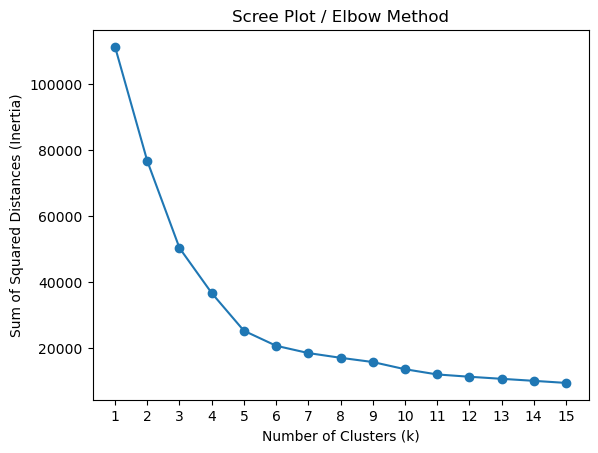

In [80]:
# Add code here
# select numeric columns for clustering
X = churn_roll_rescaled[num_cols]  # Use only the numeric features

# define range of k to try (1 to 15)
k_values = range(1, 16)  # 1 to 15 clusters
inertia_values = []       # To store sum of squared distances

# loop over k values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0) # set seed
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# plot the scree plot
plt.plot(k_values, inertia_values, marker='o')
plt.title('Scree Plot / Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.xticks(k_values)
plt.show()

3. Based on the scree plot, what is a good value to pick for $k$? Provide a brief justification for your choice. <span style="color:red" float:right>[2 point]</span>

**Add Comment here**   
Scree Plot is often referred as Elbow method, we want to find where the inertia stops decreasing drastically, this is visualized as the "elbow" part of the plot. In this case, 5 clusters would be a good pick for k. 

4. Train a k-means algorithm on the RFM features using your new value of $k$. Report:
- the size (number of items) of each cluster
- the mean of each cluster in the original scale
- the standard deviation of each cluster in the Z-normalized scale
<span style="color:red" float:right>[2 point]</span>

In [83]:
# Add code here
n_clusters = 5 # the number of clusters (k)

X = churn_roll_rescaled
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
churn_roll_rescaled['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row

# report the size of each cluster
print('\nNumber of items in each cluster:')
print(churn_roll_rescaled.cluster.value_counts())

# report the mean of each cluster in the original scale
# Make a copy of the original unscaled data
churn_roll_with_clusters = churn_roll.copy()
# Add the cluster labels learned from the normalized data
churn_roll_with_clusters['cluster'] = churn_roll_rescaled['cluster'].values

print('\nThe mean of each cluster in original scale:')
org_mean = churn_roll_with_clusters.groupby('cluster')[num_cols].mean()
display(org_mean)


# report the standard deviation of each cluster in the Z-normalized sacle
print('\nThe standard deviation of each cluster in the Z-normalized scale:')
std_z_normalized = churn_roll_rescaled.groupby('cluster')[num_cols].std()
display(std_z_normalized)



Number of items in each cluster:
cluster
0    11311
2    10212
4     5455
3     5161
1     4919
Name: count, dtype: int64

The mean of each cluster in original scale:


,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
cluster,,,
0,1336.035806,13.786403,43.921758
1,1306.257573,14.226266,36.120350
2,1142.666667,12.035546,49.447219
3,1054.794807,11.637861,39.179810
4,1296.649863,13.890742,41.971769



The standard deviation of each cluster in the Z-normalized scale:


,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
cluster,,,
0,0.887850,0.691813,1.002996
1,1.031233,0.897468,0.945743
2,1.247670,1.542579,1.031207
3,0.600057,0.497487,0.963229
4,0.963385,0.609990,0.986925


5. Pick 3 clusters at random and describe what makes them different from one another (in terms of their RFM features). <span style="color:red" float:right>[3 point]</span>

**Add Comment here**  

Cluster 0 is high values, high quantity, average recency spenders. This cluster has the highest spending, relatively high purchase quantity and moderate in days from last visits.  
Cluster 2 is moderate values, low quantity and high recency spenders. This cluster spends relatively moderately with moderate purchase qunatity but has the lowest recency, which means it has a longer time since the last visit comparing to other clusters.  
Cluster 3  is low values, low quantity and low recency spenders. This cluster is the lowest spending with lowest purchase quantity of all clusters but it has the second lowest recency, meaning users in this group visits more often. 

# End of assignment